# __Treino e testes da rede neural__
- Dataset: Porto Alegre (cap. 3)

##### Copyright 2021 Caio Azevedo - ensaios de uma dissertação. 

13 de junho de 2021 - última atualização __todo santo dia__
- ref. https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref. https://www.tensorflow.org/tutorials/structured_data/feature_columns

__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

In [1]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [3]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [4]:
def NetworkPerformance(y_teste, yhat_class):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_teste, yhat_class)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_teste, yhat_class)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_teste, yhat_class)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_teste, yhat_class)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_teste, yhat_class)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_teste, yhat_class)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_teste, yhat_class)
    print(matrix)

In [5]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
APP_PATH = os.getcwd()
dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "Input_POA.csv"))) 

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
dataset_original = dataset.copy()
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0


In [6]:
dataset.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
dataset = dataset[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0


In [7]:
dataset.shape

(100, 8)

In [8]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
mean,16.93,201.71,84.49,1904.50,2532.15,7.52,-0.00,0.5
std,13.31,109.91,64.51,441.43,483.09,1.38,0.02,0.5
min,0.99,3.42,0.93,1210.00,1507.00,5.29,-0.05,0.0
25%,5.54,98.86,34.81,1420.00,2741.00,6.38,-0.02,0.0
50%,14.25,215.45,66.71,2230.00,2741.00,7.24,-0.00,0.5
75%,25.59,306.72,126.16,2230.00,2773.00,8.37,0.01,1.0
max,50.76,355.01,257.71,2300.00,2790.00,10.82,0.07,1.0


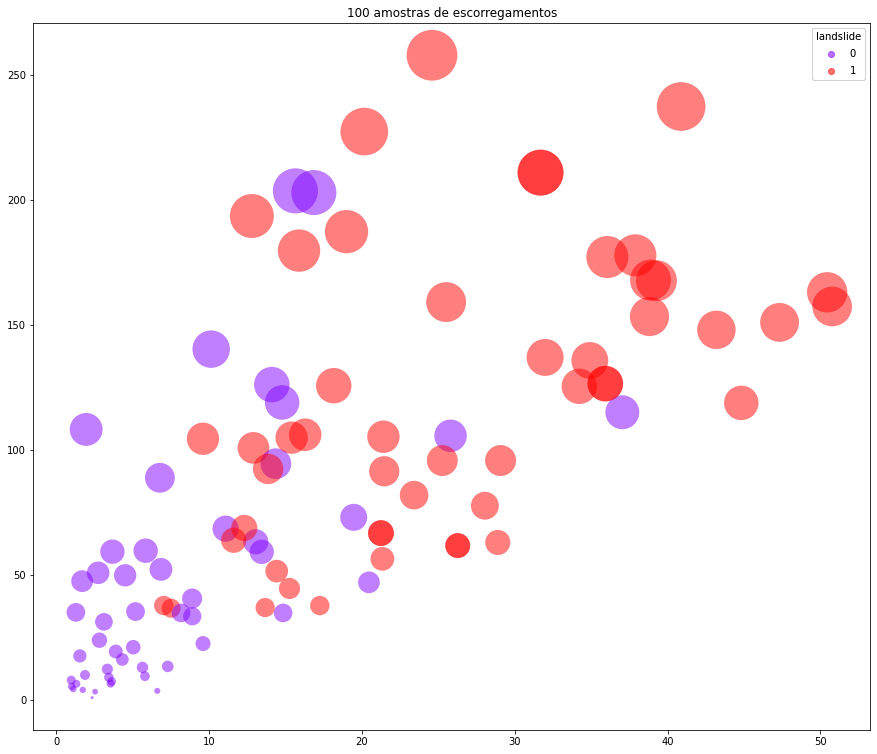

In [9]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.add_artist(legend1)
ax.title.set_text("{}{}".format(len(dataset.index), ' amostras de escorregamentos')) 

plt.show()

## Preparação dos dados (Remoção das features irrelevantes & Normalização)
__Cuidado com data leakage, considerar as melhores práticas:__
- Train-Test Evaluation With Correct Data Preparation
- ref. https://realpython.com/train-test-split-python-data/
- Data Preparation With k-fold Cross-Validation

- ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref. https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref. https://www.section.io/engineering-education/data-leakage/
- ref. https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1

 __Segue abaixo, a ordem de relevância das variáveis, bem como a identificação daquelas que podem ser removidas (vide analise análise da features).__
  - elevation | elevation (ok) 
  - uso_solo | uso_solo (ok)
  - twi | curvatura (ok)
  - curvatura | twi (ok)
  - lito | aspect   __(to be tested)__
  - aspect | lito   __(to be tested)__
  - slope | slope   __(to be tested)__

In [10]:
#features menos relevantes guaruja
#dataset = dataset.drop('aspect',axis=1)
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('slope',axis=1)

# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0


In [11]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [12]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [13]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation2(dataset)
#X_train, X_test, y_train, y_test = dataPreparation(dataset)

In [14]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

49 train examples
21 validation examples
30 test examples


In [15]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [0.76110223 0.93354354 0.85323174 1.         1.         1.03000389
 0.14596724]


In [16]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [17]:
X.shape

(100, 7)

In [18]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [19]:
y.shape

(100, 1)

In [20]:
print(X.min(axis=0), X.max(axis=0))

[-1.00090911 -1.04516353 -1.02435944 -1.         -1.         -1.
 -1.        ] [1.         1.         1.27293261 1.         1.         1.03000389
 1.        ]


In [21]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

__Computa o número de variáveis de entrada (features) e saída (sempre 1)__

In [22]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

## Rede Neural Customizada
### Força Bruta para tuning dos hiperparametros 
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

In [23]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [24]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [25]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #camada de entrada
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#regularizacao por dropout e com inicialização de pesos e bias
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,dropout_prob = droput,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#regularizacao por L2 e sem inicialização de pesos e bias
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,reg_func=l2_regularization,reg_strength=1e-2,activation=rna.relu))
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,dropout_prob = droput,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))        
    #camada de saída
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [26]:
def setBestNeuralNetwork2(num_learning_rate,input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, patience=10) 

    #camada de entrada 
    nn.layers.append(Layer(input_dim=input_dim, output_dim=20,activation= rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    nn.layers.append(Layer(input_dim=20, output_dim=10,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
    #nn.layers.append(Layer(input_dim=10, output_dim=10,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
 
    #camadad de saída
    nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=rna.sigmoid))  

    return nn

In [27]:
def setBestNeuralNetwork3(num_learning_rate,input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate,momentum=0.25, patience=10) 

    #camada de entrada - considerar tanh na segunda camada e com dropout 0.2821478566400208
    nn.layers.append(Layer(input_dim=input_dim, output_dim=7,activation= rna.relu, weights_initializer=rna.glorot_normal))

    nn.layers.append(Layer(input_dim=7, output_dim=20 ,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
    #nn.layers.append(Layer(input_dim=7, output_dim=14,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
    nn.layers.append(Layer(input_dim=20, output_dim=7,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
 
    #camada de saída
    nn.layers.append(Layer(input_dim=7, output_dim=output_dim,activation=rna.sigmoid, weights_initializer=rna.glorot_normal))  

    return nn

In [28]:
# (batch_size) implementa o mini-batch que acelera o tempo de treinamento, requer método de inicialização do mini-batch. 
#ideal que o batch_size seja multiplo do tamanho do conjunto de dados de treinamento, que aqui é de 128 

neurons = [7,8] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [1,2]
learning_rate = [0.01,0.005]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []

In [29]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Camada de Entrada: {} neurônios inputs  {} neurônios saída {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' _camada oculta {} neurônios {} camadas '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} neurônios da ultima camada oculta, {} neurônios na de saída \033[0m'.format(neurons,output_dim))

In [30]:
tot = 1
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    setTestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    tot += tot
                    #print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, {} dropout rate, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

print(tot)

 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.01 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.01 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.01 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.01 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.01 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.01 learning rate 
 _camada oculta 7 neur

In [31]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append( hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, {} dropout rate, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 1.02915045 + 0.00000000 = 1.02915045 loss_val = 1.02915045
epoch: 3000/40000 loss_train: 0.19056460 + 0.00000000 = 0.19056460 loss_val = 0.19056460
epoch: 6000/40000 loss_train: 0.17040034 + 0.00000000 = 0.17040034 loss_val = 0.17040034
epoch: 9000/40000 loss_train: 0.13572703 + 0.00000000 = 0.13572703 loss_val = 0.13572703
epoch: 12000/40000 loss_train: 0.08848937 + 0.00000000 = 0.08848937 loss_val = 0.08848937
epoch: 15000/40000 loss_train: 0.04614651 + 0.00000000 = 0.04614651 loss_val = 0.04614651
epoch: 18000/40000 loss_train: 0.02103153 + 0.00000000 = 0.02103153 loss_val = 0.02103153
epoch: 21000/40000 loss_train: 0.01079945 + 0.00000000 = 0.01079945 loss_val = 0.01079945
epoch: 24000/40000 loss_train: 0.00666726 + 0.00000000 = 0.00666726 loss_val = 0.00666726
epoch: 27000/40000 loss_train: 0.00460001 + 0.00000000 = 0.00460001 loss_val = 0.00460001
epoch: 30000/40000 loss_train: 0.00338735 + 0.00000000 = 0.00338735 loss_val = 0.00338735
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.21409806 + 0.00000000 = 0.21409806 loss_val = 0.21409806
epoch: 6000/40000 loss_train: 0.20350954 + 0.00000000 = 0.20350954 loss_val = 0.20350954
epoch: 9000/40000 loss_train: 0.19835057 + 0.00000000 = 0.19835057 loss_val = 0.19835057
epoch: 12000/40000 loss_train: 0.19383975 + 0.00000000 = 0.19383975 loss_val = 0.19383975
epoch: 15000/40000 loss_train: 0.18935931 + 0.00000000 = 0.18935931 loss_val = 0.18935931
epoch: 18000/40000 loss_train: 0.18478175 + 0.00000000 = 0.18478175 loss_val = 0.18478175
epoch: 21000/40000 loss_train: 0.18011783 + 0.00000000 = 0.18011783 loss_val = 0.18011783
epoch: 24000/40000 loss_train: 0.17523405 + 0.00000000 = 0.17523405 loss_val = 0.17523405
epoch: 27000/40000 loss_train: 0.17013274 + 0.00000000 = 0.17013274 loss_val = 0.17013274
epoch: 30000/40000 loss_train: 0.16482424 + 0.00000000 = 0.16482424 loss_val = 0.16482424
epoch: 33000/40000 loss_train: 0.15923079 + 0.00000000 = 0.15923079 loss_val = 0.15923079
epoch: 36000/

epoch: 3000/40000 loss_train: 0.27469865 + 0.00000000 = 0.27469865 loss_val = 0.27469865
Para 8 neurônios, 1 camadas,  0.01 learning rate, 8 batch size, 0.1 dropout rate, temos:  Acurácia: 90.48% 
epoch:    0/40000 loss_train: 0.69520162 + 0.00000000 = 0.69520162 loss_val = 0.69520162
epoch: 3000/40000 loss_train: 0.21973262 + 0.00000000 = 0.21973262 loss_val = 0.21973262
epoch: 6000/40000 loss_train: 0.18951586 + 0.00000000 = 0.18951586 loss_val = 0.18951586
epoch: 9000/40000 loss_train: 0.17281372 + 0.00000000 = 0.17281372 loss_val = 0.17281372
epoch: 12000/40000 loss_train: 0.15100722 + 0.00000000 = 0.15100722 loss_val = 0.15100722
epoch: 15000/40000 loss_train: 0.13021156 + 0.00000000 = 0.13021156 loss_val = 0.13021156
epoch: 18000/40000 loss_train: 0.11051380 + 0.00000000 = 0.11051380 loss_val = 0.11051380
epoch: 21000/40000 loss_train: 0.09247754 + 0.00000000 = 0.09247754 loss_val = 0.09247754
epoch: 24000/40000 loss_train: 0.07603045 + 0.00000000 = 0.07603045 loss_val = 0.076030

C:\Users\cazev\OneDrive\Desktop\docs\Python\notebooks\Mestrado\dissertacao\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Users\cazev\OneDrive\Desktop\docs\Python\notebooks\Mestrado\dissertacao\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Users\cazev\OneDrive\Desktop\docs\Python\notebooks\Mestrado\dissertacao\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


Para 7 neurônios, 2 camadas,  0.01 learning rate, 0 batch size, 0 dropout rate, temos:  Acurácia: 47.62% 
epoch:    0/40000 loss_train: 1.09218290 + 0.00000000 = 1.09218290 loss_val = 1.09218290
epoch: 3000/40000 loss_train: 0.18641992 + 0.00000000 = 0.18641992 loss_val = 0.18641992
epoch: 6000/40000 loss_train: 0.14181596 + 0.00000000 = 0.14181596 loss_val = 0.14181596
Para 7 neurônios, 2 camadas,  0.01 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 90.48% 
epoch:    0/40000 loss_train: 0.89402939 + 0.00000000 = 0.89402939 loss_val = 0.89402939
epoch: 3000/40000 loss_train: 0.20578065 + 0.00000000 = 0.20578065 loss_val = 0.20578065
epoch: 6000/40000 loss_train: 0.19064706 + 0.00000000 = 0.19064706 loss_val = 0.19064706
epoch: 9000/40000 loss_train: 0.17901093 + 0.00000000 = 0.17901093 loss_val = 0.17901093
epoch: 12000/40000 loss_train: 0.16738915 + 0.00000000 = 0.16738915 loss_val = 0.16738915
epoch: 15000/40000 loss_train: 0.15595850 + 0.00000000 = 0.15595850 loss_

epoch: 30000/40000 loss_train: 0.00607028 + 0.00000000 = 0.00607028 loss_val = 0.00607028
epoch: 33000/40000 loss_train: 0.00396154 + 0.00000000 = 0.00396154 loss_val = 0.00396154
epoch: 36000/40000 loss_train: 0.00284345 + 0.00000000 = 0.00284345 loss_val = 0.00284345
epoch: 39000/40000 loss_train: 0.00216883 + 0.00000000 = 0.00216883 loss_val = 0.00216883
Para 7 neurônios, 2 camadas,  0.005 learning rate, 8 batch size, 0 dropout rate, temos:  Acurácia: 90.48% 
epoch:    0/40000 loss_train: 1.02914262 + 0.00000000 = 1.02914262 loss_val = 1.02914262
epoch: 3000/40000 loss_train: 0.22987068 + 0.00000000 = 0.22987068 loss_val = 0.22987068
Para 7 neurônios, 2 camadas,  0.005 learning rate, 8 batch size, 0.1 dropout rate, temos:  Acurácia: 90.48% 
epoch:    0/40000 loss_train: 0.82484739 + 0.00000000 = 0.82484739 loss_val = 0.82484739
epoch: 3000/40000 loss_train: 0.17269556 + 0.00000000 = 0.17269556 loss_val = 0.17269556
epoch: 6000/40000 loss_train: 0.09329895 + 0.00000000 = 0.09329895 l

epoch: 36000/40000 loss_train: 0.00291589 + 0.00000000 = 0.00291589 loss_val = 0.00291589
epoch: 39000/40000 loss_train: 0.00220584 + 0.00000000 = 0.00220584 loss_val = 0.00220584
Para 8 neurônios, 2 camadas,  0.005 learning rate, 4 batch size, 0 dropout rate, temos:  Acurácia: 90.48% 
epoch:    0/40000 loss_train: 0.79964228 + 0.00000000 = 0.79964228 loss_val = 0.79964228
epoch: 3000/40000 loss_train: 0.25409531 + 0.00000000 = 0.25409531 loss_val = 0.25409531
epoch: 6000/40000 loss_train: 0.19848904 + 0.00000000 = 0.19848904 loss_val = 0.19848904
Para 8 neurônios, 2 camadas,  0.005 learning rate, 4 batch size, 0.1 dropout rate, temos:  Acurácia: 95.24% 
epoch:    0/40000 loss_train: 0.67421103 + 0.00000000 = 0.67421103 loss_val = 0.67421103
epoch: 3000/40000 loss_train: 0.21844852 + 0.00000000 = 0.21844852 loss_val = 0.21844852
epoch: 6000/40000 loss_train: 0.19572128 + 0.00000000 = 0.19572128 loss_val = 0.19572128
epoch: 9000/40000 loss_train: 0.17102241 + 0.00000000 = 0.17102241 los

In [32]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

100.00% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.005 de learning rate e 0 de batch size!


In [33]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann.acuracia,best_ann.ann))

100.00% foi a melhor acurácia, obtida com a rede <Rede_Neural.NeuralNetwork object at 0x0000022AC4B116A0> 


In [34]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

47.62% foi a melhor acurácia, obtida com 2 camadas,7 neurônios, 0.01 de learning rate, 0 de batch size e 0 dropout rate!
47.62% foi a melhor acurácia, obtida com 2 camadas,8 neurônios, 0.01 de learning rate, 4 de batch size e 0 dropout rate!
47.62% foi a melhor acurácia, obtida com 2 camadas,8 neurônios, 0.01 de learning rate, 8 de batch size e 0 dropout rate!
80.95% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.01 de learning rate, 0 de batch size e 0 dropout rate!
80.95% foi a melhor acurácia, obtida com 1 camadas,8 neurônios, 0.01 de learning rate, 8 de batch size e 0 dropout rate!
85.71% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.01 de learning rate, 0 de batch size e 0.1 dropout rate!
85.71% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.01 de learning rate, 4 de batch size e 0 dropout rate!
85.71% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.01 de learning rate, 8 de batch size e 0.1 dropout rate!
85.71% foi a melhor acurácia

In [35]:
lst_hyperP = []
lst_ANN = []

for num_learning_rate in learning_rate:
    for num_batch_size in batch_size:
        nn = setBestNeuralNetwork2(num_learning_rate, input_dim, output_dim)

        nn.fit(X_train, y_train, epochs=46000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

        y_pred = nn.predict(X_val)
        accu = 100*accuracy_score(y_val, y_pred > 0.5)
        #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
        lst_hyperP.append( hyperparametros(accu,2,10,num_learning_rate,num_batch_size,0) )
        lst_ANN.append(ANN_accuracy(accu,nn))
        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

epoch:    0/46000 loss_train: 0.81906469 + 0.00000000 = 0.81906469 loss_val = 0.81906469
epoch: 3000/46000 loss_train: 0.13115577 + 0.00000000 = 0.13115577 loss_val = 0.13115577
epoch: 6000/46000 loss_train: 0.05686032 + 0.00000000 = 0.05686032 loss_val = 0.05686032
epoch: 9000/46000 loss_train: 0.02299366 + 0.00000000 = 0.02299366 loss_val = 0.02299366
epoch: 12000/46000 loss_train: 0.01149211 + 0.00000000 = 0.01149211 loss_val = 0.01149211
epoch: 15000/46000 loss_train: 0.00688971 + 0.00000000 = 0.00688971 loss_val = 0.00688971
epoch: 18000/46000 loss_train: 0.00465878 + 0.00000000 = 0.00465878 loss_val = 0.00465878
epoch: 21000/46000 loss_train: 0.00341212 + 0.00000000 = 0.00341212 loss_val = 0.00341212
epoch: 24000/46000 loss_train: 0.00263919 + 0.00000000 = 0.00263919 loss_val = 0.00263919
epoch: 27000/46000 loss_train: 0.00212281 + 0.00000000 = 0.00212281 loss_val = 0.00212281
epoch: 30000/46000 loss_train: 0.00175818 + 0.00000000 = 0.00175818 loss_val = 0.00175818
epoch: 33000/4

epoch: 24000/46000 loss_train: 0.04410483 + 0.00000000 = 0.04410483 loss_val = 0.04410483
epoch: 27000/46000 loss_train: 0.03221025 + 0.00000000 = 0.03221025 loss_val = 0.03221025
epoch: 30000/46000 loss_train: 0.02415799 + 0.00000000 = 0.02415799 loss_val = 0.02415799
epoch: 33000/46000 loss_train: 0.01854308 + 0.00000000 = 0.01854308 loss_val = 0.01854308
epoch: 36000/46000 loss_train: 0.01431950 + 0.00000000 = 0.01431950 loss_val = 0.01431950
epoch: 39000/46000 loss_train: 0.01146590 + 0.00000000 = 0.01146590 loss_val = 0.01146590
epoch: 42000/46000 loss_train: 0.00938145 + 0.00000000 = 0.00938145 loss_val = 0.00938145
epoch: 45000/46000 loss_train: 0.00782620 + 0.00000000 = 0.00782620 loss_val = 0.00782620
Para  0.005 learning rate, 8 batch size, temos:  Acurácia: 95.24% 


In [36]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

85.71% foi a melhor acurácia, obtida com 2 camadas, 0.01 de learning rate, 0 de batch size e 0 dropout rate!
90.48% foi a melhor acurácia, obtida com 2 camadas, 0.01 de learning rate, 8 de batch size e 0 dropout rate!
90.48% foi a melhor acurácia, obtida com 2 camadas, 0.005 de learning rate, 0 de batch size e 0 dropout rate!
90.48% foi a melhor acurácia, obtida com 2 camadas, 0.005 de learning rate, 4 de batch size e 0 dropout rate!
95.24% foi a melhor acurácia, obtida com 2 camadas, 0.005 de learning rate, 8 de batch size e 0 dropout rate!
100.00% foi a melhor acurácia, obtida com 2 camadas, 0.01 de learning rate, 4 de batch size e 0 dropout rate!


In [37]:
best_ann2 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann2.acuracia,best_ann2.ann))
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann2.acuracia,best_ann2.ann))

100.00% foi a melhor acurácia, obtida com a rede <Rede_Neural.NeuralNetwork object at 0x0000022AC4AF1D90> 


In [38]:
lst_hyperP = []
lst_ANN = []

for num_learning_rate in learning_rate:
    for num_batch_size in batch_size:
        nn = setBestNeuralNetwork3(num_learning_rate, input_dim, output_dim)

        nn.fit(X_train, y_train, epochs=36000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

        y_pred = nn.predict(X_val)
        accu = 100*accuracy_score(y_val, y_pred > 0.5)
        #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
        lst_hyperP.append( hyperparametros(accu,3,3,num_learning_rate,num_batch_size,0) )
        lst_ANN.append(ANN_accuracy(accu,nn))
        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

epoch:    0/36000 loss_train: 0.85322438 + 0.00000000 = 0.85322438 loss_val = 0.85322438
epoch: 3000/36000 loss_train: 0.22002424 + 0.00000000 = 0.22002424 loss_val = 0.22002424
epoch: 6000/36000 loss_train: 0.17148762 + 0.00000000 = 0.17148762 loss_val = 0.17148762
epoch: 9000/36000 loss_train: 0.10946781 + 0.00000000 = 0.10946781 loss_val = 0.10946781
Para  0.01 learning rate, 0 batch size, temos:  Acurácia: 90.48% 
epoch:    0/36000 loss_train: 0.91139517 + 0.00000000 = 0.91139517 loss_val = 0.91139517
epoch: 3000/36000 loss_train: 0.16677877 + 0.00000000 = 0.16677877 loss_val = 0.16677877
epoch: 6000/36000 loss_train: 0.06833561 + 0.00000000 = 0.06833561 loss_val = 0.06833561
epoch: 9000/36000 loss_train: 0.01482841 + 0.00000000 = 0.01482841 loss_val = 0.01482841
epoch: 12000/36000 loss_train: 0.00468606 + 0.00000000 = 0.00468606 loss_val = 0.00468606
epoch: 15000/36000 loss_train: 0.00231573 + 0.00000000 = 0.00231573 loss_val = 0.00231573
epoch: 18000/36000 loss_train: 0.00142442 

In [39]:
best_ann3 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann3.acuracia,best_ann3.ann))
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann3.acuracia,best_ann3.ann))

90.48% foi a melhor acurácia, obtida com a rede <Rede_Neural.NeuralNetwork object at 0x0000022AC481FE50> 


In [40]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

71.43% foi a melhor acurácia, obtida com 3 camadas, 0.005 de learning rate, 0 de batch size e 0 dropout rate!
80.95% foi a melhor acurácia, obtida com 3 camadas, 0.005 de learning rate, 8 de batch size e 0 dropout rate!
85.71% foi a melhor acurácia, obtida com 3 camadas, 0.01 de learning rate, 4 de batch size e 0 dropout rate!
90.48% foi a melhor acurácia, obtida com 3 camadas, 0.01 de learning rate, 0 de batch size e 0 dropout rate!
90.48% foi a melhor acurácia, obtida com 3 camadas, 0.01 de learning rate, 8 de batch size e 0 dropout rate!
90.48% foi a melhor acurácia, obtida com 3 camadas, 0.005 de learning rate, 4 de batch size e 0 dropout rate!


# Avaliação da rede Proprietária

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

Primeira abordagem, recuperar a melhor configuração de rede da otimização por força bruta

In [41]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))
  print('{:.2f}% accu_test - {:.2f}% foi a melhor\033[1m acurácia\033[0m, {} RNA!'.format(accu,best_RNA.acuracia,best_RNA.ann))

80.00% accu_test - 100.00% foi a melhor acurácia, <Rede_Neural.NeuralNetwork object at 0x0000022AC4B116A0> RNA!
80.00% accu_test - 100.00% foi a melhor acurácia, <Rede_Neural.NeuralNetwork object at 0x0000022AC4AF1D90> RNA!
80.00% accu_test - 90.48% foi a melhor acurácia, <Rede_Neural.NeuralNetwork object at 0x0000022AC481FE50> RNA!


In [42]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [43]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

80.00%, acurácia de teste !


Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [44]:
bestNN = max(best_of_best_ANN, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [45]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

80.00%, acurácia de teste !


__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [46]:
if accu >= 80:
    print('{:.2f}%, ótima acurácia de teste, rede salva!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Acurácia: {:.2f}% acurácia de validação abaixo de .80!'.format(accu))

80.00%, ótima acurácia de teste, rede salva!


In [47]:
y_pred = bestNN.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia: 100.00%


In [48]:
y_pred = bestNN.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia: 100.00%


In [49]:
y_pred = bestNN.predict(X_test)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 80.00%


In [50]:
y_pred = bestNN.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Acurácia: 94.00%


__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [51]:
yhat_probs = bestNN.predict(X_train)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_train, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 100.00%


In [52]:
NetworkPerformance(y_train, yhat_classes)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[26  0]
 [ 0 23]]


In [53]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 80.00%


In [54]:
NetworkPerformance(y_test, yhat_classes)

Accuracy: 0.800000
Precision: 1.000000
Recall: 0.625000
F1 score: 0.769231
Cohens kappa: 0.608696
ROC AUC: 0.812500
[[14  0]
 [ 6 10]]


In [55]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 100.00%


In [56]:
NetworkPerformance(y_val, yhat_classes)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[10  0]
 [ 0 11]]


In [57]:
yhat_probs = bestNN.predict(X)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 94.00%


In [58]:
NetworkPerformance(y, yhat_classes)

Accuracy: 0.940000
Precision: 1.000000
Recall: 0.880000
F1 score: 0.936170
Cohens kappa: 0.880000
ROC AUC: 0.940000
[[50  0]
 [ 6 44]]


Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [59]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [60]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

[-1.00090911 -1.04516353 -1.02435944 -1.         -1.         -1.
 -1.        ] [1.         1.         1.27293261 1.         1.         1.03000389
 1.        ]


In [61]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Numero de Splits_stratified de X:  10 

(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)


In [62]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [90.0, 90.0, 95.0, 95.0, 100.0, 90.0, 90.0, 95.0, 95.0, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 90.0 %

Acurácia média: 94.0 %

Desvio Padrão: 3.9440531887330774


Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [63]:
dataset

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0
...,...,...,...,...,...,...,...,...
95,37.890990,336.34500,177.72200,2230,2773,6.217178,-0.021211,1
96,7.045130,99.54131,37.76530,1420,2742,9.468263,-0.018692,1
97,16.295700,216.57440,106.03300,2230,2773,9.182029,-0.015873,1
98,3.906067,50.09582,19.37700,2210,1507,7.014249,-0.000092,0


In [64]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

Acurácia: 94.00%


In [65]:
NetworkPerformance(y, yhat_classes)

Accuracy: 0.940000
Precision: 1.000000
Recall: 0.880000
F1 score: 0.936170
Cohens kappa: 0.880000
ROC AUC: 0.940000
[[50  0]
 [ 6 44]]


In [66]:
output_proprietario

,slope,aspect,elevation,uso_solo,lito,twi,curv,class,score
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0,2.167229e-02
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0,4.371471e-04
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0,1.615221e-10
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0,5.778373e-20
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0,1.676645e-20
...,...,...,...,...,...,...,...,...,...
95,37.890990,336.34500,177.72200,2230,2773,6.217178,-0.021211,1,9.999923e-01
96,7.045130,99.54131,37.76530,1420,2742,9.468263,-0.018692,1,9.791648e-19
97,16.295700,216.57440,106.03300,2230,2773,9.182029,-0.015873,1,1.338313e-01
98,3.906067,50.09582,19.37700,2210,1507,7.014249,-0.000092,0,1.844820e-03


ROC AUC=0.960


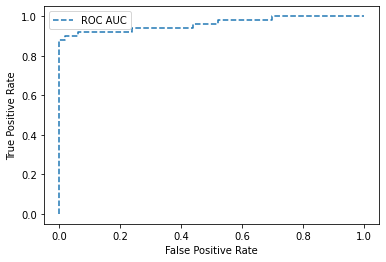

In [67]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

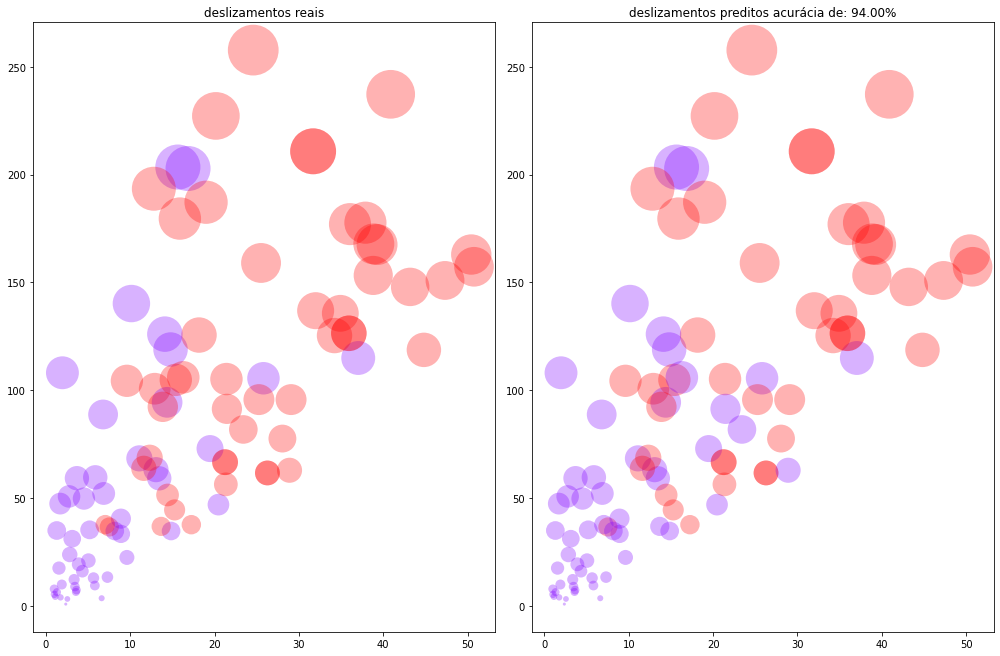

In [68]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


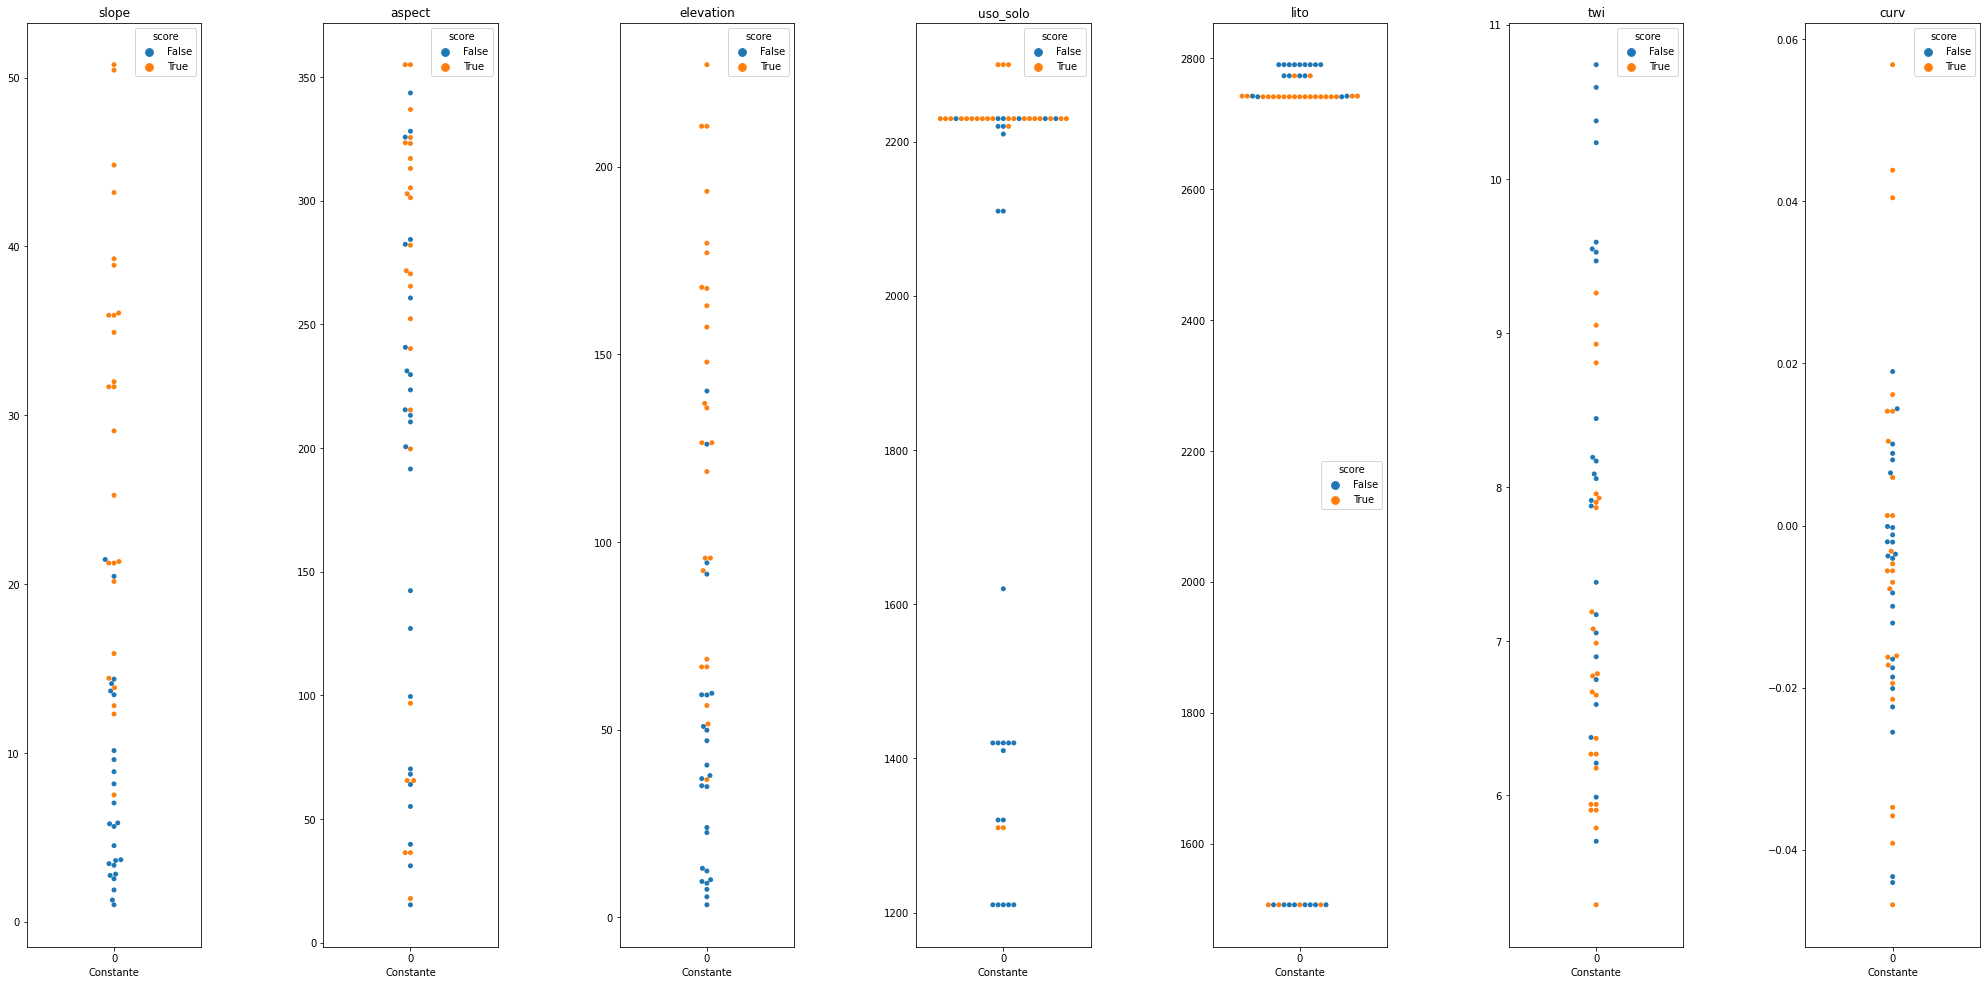

In [69]:
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [70]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

## Rede Neural  Keras
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [71]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [72]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

49 train examples
21 validation examples
30 test examples


In [73]:
#{'num_hidden_layers': 1, 'num_units': 4, 'dropout_rate': 0.5, 'learning_rate': 0.004682800657889146}       

In [74]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [75]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(10, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(10, activation='relu'))
hypermodel.add(Dropout(0.2821478566400208))
hypermodel.add(Dense(10, activation='tanh'))
hypermodel.add(Dropout(0.2821478566400208))

hypermodel.add(Dense(1, activation='sigmoid'))
hypermodel.compile(optimizer=keras.optimizers.Adam(0.004682800657889146), loss="binary_crossentropy", metrics=['accuracy'])

In [76]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
10/10 [==============================] - 1s 1ms/step - loss: 0.6635 - accuracy: 0.5714
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.8980
Epoch 3/500
10/10 [==============================] - 0s 1ms/step - loss: 0.5556 - accuracy: 0.6735
Epoch 4/500
10/10 [==============================] - 0s 1ms/step - loss: 0.4692 - accuracy: 0.7959
Epoch 5/500
10/10 [==============================] - 0s 1ms/step - loss: 0.5052 - accuracy: 0.7551
Epoch 6/500
10/10 [==============================] - 0s 1ms/step - loss: 0.4707 - accuracy: 0.7551
Epoch 7/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3700 - accuracy: 0.8776
Epoch 8/500
10/10 [==============================] - 0s 1ms/step - loss: 0.4145 - accuracy: 0.7959
Epoch 9/500
10/10 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8571
Epoch 10/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3285 - accuracy: 0.8367
Epoch 11/

10/10 [==============================] - 0s 1ms/step - loss: 0.0293 - accuracy: 1.0000
Epoch 84/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 1.0000
Epoch 85/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0276 - accuracy: 1.0000
Epoch 86/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 87/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0269 - accuracy: 0.9796
Epoch 88/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 89/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0444 - accuracy: 0.9592
Epoch 90/500
10/10 [==============================] - 0s 1ms/step - loss: 0.1016 - accuracy: 0.9592
Epoch 91/500
10/10 [==============================] - 0s 1ms/step - loss: 0.1610 - accuracy: 0.9388
Epoch 92/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.9796
Epoch 93/500


10/10 [==============================] - 0s 997us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 245/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 246/500
10/10 [==============================] - 0s 1ms/step - loss: 4.2713e-04 - accuracy: 1.0000
Epoch 247/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0200 - accuracy: 0.9796
Epoch 248/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 249/500
10/10 [==============================] - 0s 1ms/step - loss: 5.4998e-04 - accuracy: 1.0000
Epoch 250/500
10/10 [==============================] - 0s 1ms/step - loss: 2.0255e-04 - accuracy: 1.0000
Epoch 251/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0165 - accuracy: 1.0000
Epoch 252/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 253/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0171 - accurac

10/10 [==============================] - 0s 1ms/step - loss: 5.1845e-04 - accuracy: 1.0000
Epoch 405/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.9796
Epoch 406/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0347 - accuracy: 0.9796
Epoch 407/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0158 - accuracy: 1.0000
Epoch 408/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.9796
Epoch 409/500
10/10 [==============================] - 0s 997us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 410/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0110 - accuracy: 1.0000
Epoch 411/500
10/10 [==============================] - 0s 997us/step - loss: 0.0128 - accuracy: 1.0000
Epoch 412/500
10/10 [==============================] - 0s 1ms/step - loss: 6.7425e-04 - accuracy: 1.0000
Epoch 413/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy:

In [77]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 47


In [78]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 155ms/step - loss: 2.1490 - accuracy: 0.8333
Accuracy: 83.33


In [79]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/47
2/2 [==============================] - 0s 2ms/step - loss: 1.2882e-04 - accuracy: 1.0000
Epoch 2/47
2/2 [==============================] - 0s 2ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 3/47
2/2 [==============================] - 0s 2ms/step - loss: 3.3031e-04 - accuracy: 1.0000
Epoch 4/47
2/2 [==============================] - 0s 2ms/step - loss: 1.1971e-04 - accuracy: 1.0000
Epoch 5/47
2/2 [==============================] - 0s 2ms/step - loss: 1.5965e-04 - accuracy: 1.0000
Epoch 6/47
2/2 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/47
2/2 [==============================] - 0s 3ms/step - loss: 0.0130 - accuracy: 1.0000
Epoch 8/47
2/2 [==============================] - 0s 2ms/step - loss: 2.5421e-04 - accuracy: 1.0000
Epoch 9/47
2/2 [==============================] - 0s 2ms/step - loss: 2.6298e-04 - accuracy: 1.0000
Epoch 10/47
2/2 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 11/47
2/2

In [80]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 22ms/step - loss: 2.0726 - accuracy: 0.8333
Accuracy: 83.33


In [81]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [82]:
if accuracy >= .80:
    print('ótima acurácia, rede salva!')
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('acurácia abaixo de .85')

ótima acurácia, rede salva!
INFO:tensorflow:Assets written to: bestANN\suscetibilidadeKeras_guaruja.pkl\assets


# Avaliação da rede keras

In [83]:
#X = dataset.drop('class',axis=1)
#y = dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

In [84]:
#X

In [85]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Numero de Splits de X:  10 



In [86]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [90.0, 95.0, 90.0, 95.0, 95.0, 90.0, 80.0, 100.0, 95.0, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 80.0 %

Acurácia média: 93.0 %

Desvio Padrão: 5.868938953886336


In [87]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 83.33%


In [88]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia: 100.00%


In [89]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia: 90.48%


In [90]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Acurácia: 93.00%


In [91]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

,slope,aspect,elevation,uso_solo,lito,twi,curv,class,score
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0,2.265346e-05
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0,8.544948e-07
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0,7.073682e-07
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0,6.140800e-07
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0,6.175002e-07
...,...,...,...,...,...,...,...,...,...
95,37.890990,336.34500,177.72200,2230,2773,6.217178,-0.021211,1,9.999992e-01
96,7.045130,99.54131,37.76530,1420,2742,9.468263,-0.018692,1,6.144479e-07
97,16.295700,216.57440,106.03300,2230,2773,9.182029,-0.015873,1,9.999988e-01
98,3.906067,50.09582,19.37700,2210,1507,7.014249,-0.000092,0,6.491931e-07


ROC AUC=0.962


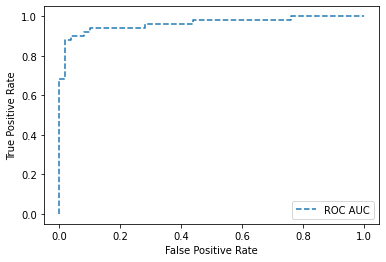

In [92]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

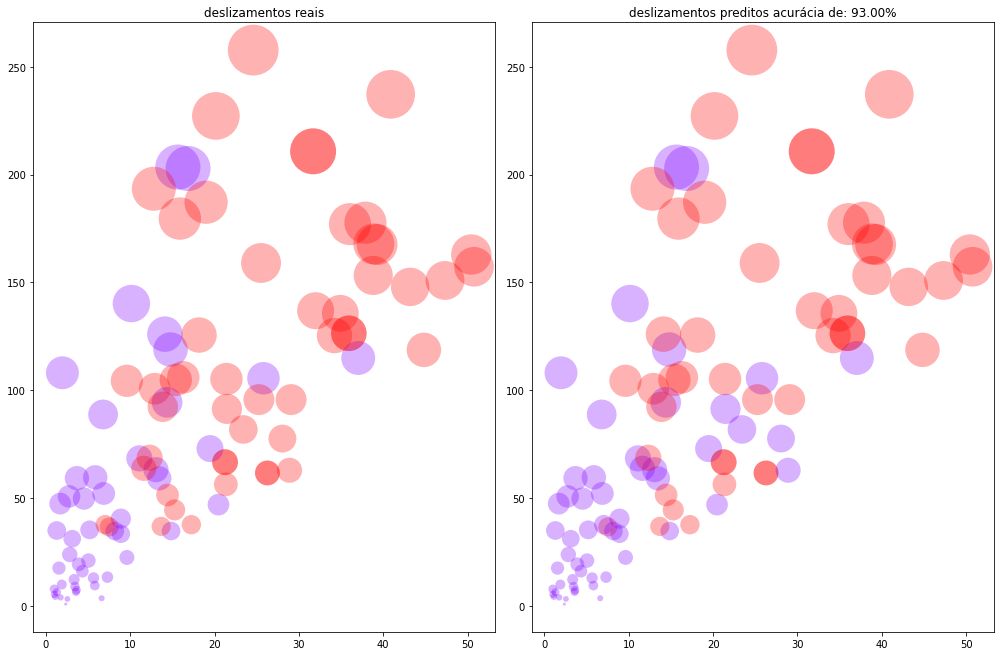

In [93]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Users\cazev\miniconda3\envs\caio\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


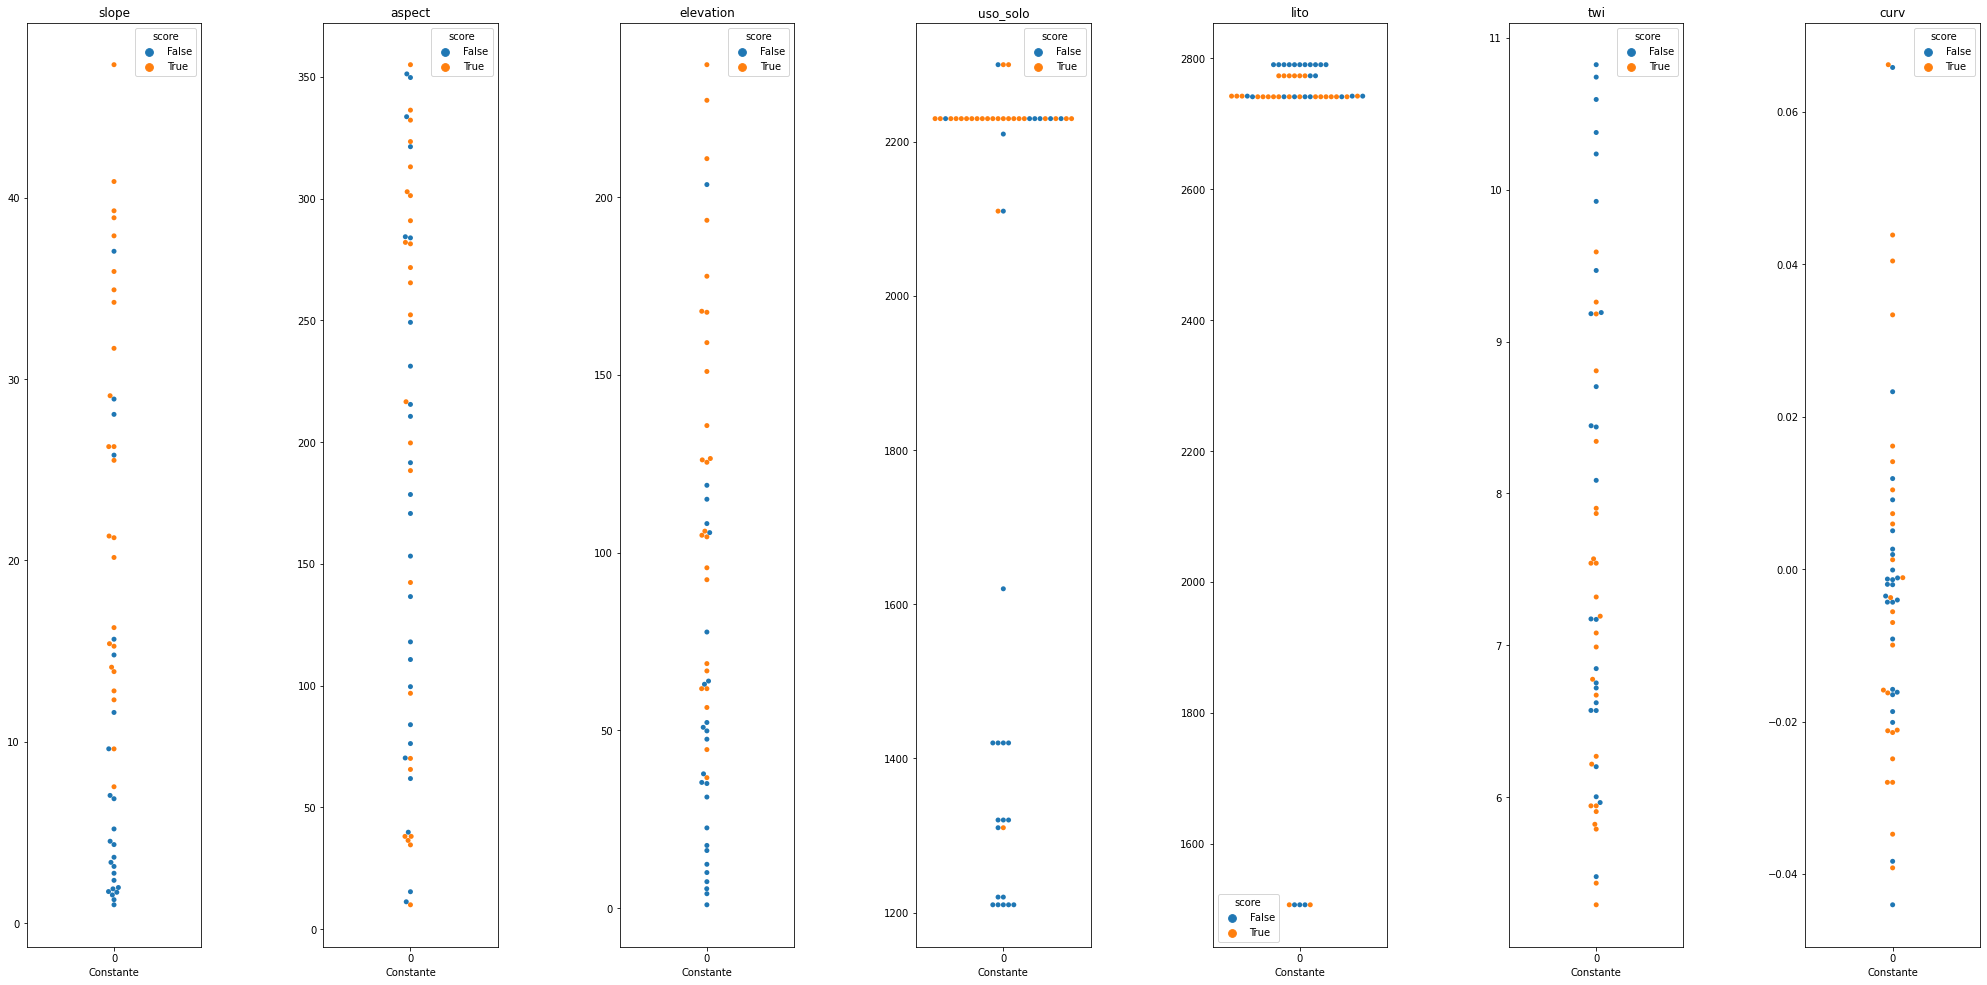

In [94]:
dataSet = output_keras.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)